In [5]:
from imagehash import phash, dhash, average_hash
import numpy as np
#from scipy.spatial.distance import hamming

### Hashing Module

In [6]:
import os
import scipy.fftpack
import numpy as np
from PIL import Image
from pathlib import Path
from types import FunctionType
from typing import Tuple

"""
TODO:
refactor: Make another function for hash generation given 8 by 8 hash matrix
Add wavelet hash?
"""


class Hashing:
    def __init__(self):
        pass

    @staticmethod
    def bool_to_hex(x: np.array) -> str:
        str_bool = ''.join([str(int(i)) for i in x])
        int_base2 = int(str_bool, 2)  # int base 2
        return '{:0x}'.format(int_base2)

    @staticmethod
    def hamming_distance(hash1: str, hash2: str) -> float:
        return np.sum([i != j for i, j in zip(hash1, hash2)])

    @staticmethod
    def run_hash_on_dir(path_dir: Path, hashing_function: FunctionType) -> dict:
        filenames = [os.path.join(path_dir, i) for i in os.listdir(path_dir) if i != '.DS_Store']
        hash_dict = dict(zip(filenames, [None] * len(filenames)))
        for i in filenames:
            hash_dict[i] = hashing_function(Path(i))
        return hash_dict

    @staticmethod
    def image_preprocess(path_image: Path, resize_dims: Tuple[int, int]) -> np.array:
        im = Image.open(path_image)
        im_res = im.resize(resize_dims, Image.ANTIALIAS)
        im_gray = im_res.convert('L')  # convert to grayscale (i.e., single channel)
        im_gray_arr = np.array(im_gray)
        return im_gray_arr

    def convert_to_array(self, path_image: None, resize_dims: Tuple[int, int] = (8, 8)) -> np.ndarray:
        try:
            if isinstance(path_image, Path):
                im_gray_arr = self.image_preprocess(path_image, resize_dims)
            elif isinstance(path_image, np.ndarray):
                im = Image.fromarray(path_image)
                im_res = im.resize(resize_dims, Image.ANTIALIAS)
                im_gray = im_res.convert('L')
                im_gray_arr = np.array(im_gray)
            else:
                raise Exception
            return im_gray_arr
        except Exception:
            print('Check Input Format! Input should be either a Path Variable or a numpy array!')
            raise

    def get_hash(self, hash_mat: np.array, n_blocks: int) -> str:
        calculated_hash = []
        for i in np.array_split(np.ndarray.flatten(hash_mat), n_blocks):
            calculated_hash.append(self.bool_to_hex(i))
        return ''.join(calculated_hash)

    def phash(self, path_image: None) -> str:
        """Implementation reference: http://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html"""
        res_dims = (32, 32)
        im_gray_arr = self.convert_to_array(path_image, resize_dims=res_dims)
        dct_coef = scipy.fftpack.dct(scipy.fftpack.dct(im_gray_arr, axis=0), axis=1)
        dct_reduced_coef = dct_coef[:8, :8]  # retain top left 8 by 8 dct coefficients
        mean_coef_val = np.mean(np.ndarray.flatten(dct_reduced_coef)[1:])  # average of coefficients excluding the DC
        # term (0th term)
        hash_mat = dct_reduced_coef >= mean_coef_val  # All coefficients greater than mean of coefficients
        return self.get_hash(hash_mat, 16)  # 16 character output

    def ahash(self, path_image: Path) -> str:
        res_dims = (8, 8)
        im_gray_arr = self.convert_to_array(path_image, resize_dims=res_dims)
        avg_val = np.mean(im_gray_arr)
        hash_mat = im_gray_arr >= avg_val
        return self.get_hash(hash_mat, 16)  # 16 character output

    def dhash(self, path_image: Path) -> str:
        """Implementation reference: http://www.hackerfactor.com/blog/index.php?/archives/529-Kind-of-Like-That.html"""
        res_dims = (9, 8)
        im_gray_arr = self.convert_to_array(path_image, resize_dims=res_dims)
        # hash_mat = im_gray_arr[:, :-1] > im_gray_arr[:, 1:]  # Calculates difference between consecutive columns
        hash_mat = im_gray_arr[:, 1:] > im_gray_arr[:, :-1]
        return self.get_hash(hash_mat, 16)  # 16 character output

    def phash_dir(self, path_dir: Path) -> dict:
        return self.run_hash_on_dir(path_dir, self.phash)

    def ahash_dir(self, path_dir: Path) -> dict:
        return self.run_hash_on_dir(path_dir, self.ahash)

    def dhash_dir(self, path_dir: Path) -> dict:
        return self.run_hash_on_dir(path_dir, self.dhash)


### Fingerprinting Module

In [7]:
from types import FunctionType
import os
import random
from PIL import Image
from copy import deepcopy
from numpy import array

class Dataset:
    """
    Class wrapper to instantiate a Dataset object composing of a subset of test images
    and a smaller fraction of images that are used as queries to test search and retrieval.
    Object contains hashed image fingerprints as well, however, hashing method is set by user.
    """
    def __init__(self, path_to_queries: str, path_to_test: str) -> None:
        #print(path_to_queries, path_to_test)
        self.query_docs = self.load_image_set(path_to_queries)
        self.test_docs = self.load_image_set(path_to_test)

    @staticmethod
    def load_image_set(path: str) -> dict: 
        return {doc: os.path.join(path, doc) for doc in os.listdir(path) if doc.endswith('.jpg')}


class HashedDataset(Dataset):
    def __init__(self, hashing_function: FunctionType, *args, **kwargs) -> None:
        super(HashedDataset, self).__init__(*args, **kwargs)
        self.hasher = hashing_function
        # self.test_hashes = {doc: str(self.hasher(Image.open(self.test_docs[doc]))) for doc in self.test_docs}
        # self.query_hashes = {doc: str(self.hasher(Image.open(self.query_docs[doc]))) for doc in self.query_docs}
        self.fingerprint()
        self.doc2hash = deepcopy(self.test_hashes)
        #self.doc2hash.update(self.query_hashes)
        self.hash2doc = {self.doc2hash[doc]: doc for doc in self.doc2hash}

    
    def fingerprint(self) -> None:
        self.test_hashes = {doc: str(self.hasher(array(Image.open(self.test_docs[doc])))) for doc in self.test_docs}
        self.query_hashes = {doc: str(self.hasher(array(Image.open(self.query_docs[doc])))) for doc in self.query_docs}
        
        
    def get_hashes(self) -> dict:
        return self.doc2hash


    def get_query_hashes(self) -> dict:
        return self.query_hashes


    def get_test_hashes(self) -> dict:
        return self.test_hashes

#### Initialize a `HashedDataset` Object

In [8]:
d_hasher = Hashing().dhash


dobj = HashedDataset(
        d_hasher,
        '/Users/zubin.john/forge/image-dedup/Transformed_dataset/Query/',
        '/Users/zubin.john/forge/image-dedup/Transformed_dataset/Retrieval/'
    )

### Retrieval Module

In [40]:
class ResultSet:
    def __init__(self, test:dict, queries: dict) -> None:
        # self.db_path = f'{index_save_path}.db'
        # self.db = self.create_db_index(index_save_path)
        self.candidates = test
        self.queries = queries
        self.fetch_nearest_neighbors()
        #self.destroy_db_index()

#     @staticmethod
#     def create_db_index(path) -> shelve.DbfilenameShelf:
#         return shelve.open(path, writeback=True)
   

    @staticmethod
    def build_query_vector(query) -> list:
        return [query] * self.n_candidates


#     def refresh_db_buffer(self) -> shelve.DbfilenameShelf:
#         return shelve.open(self.db_path)

    def fetch_query_result(self, query) -> dict:
        hammer = Hashing().hamming_distance
        return {item: hammer(query, item) for item in self.candidates if hammer(query, item) < 5}


#     def populate_db(self, candidates: dict):
#         for each in candidates:
#             self.db[candidates[each]] = self.db.get(candidates[each], []) + [each]
#         # Close the shelf database
#         self.db.close()


    def fetch_nearest_neighbors(self) -> None:
        sorted_results = {}
        for each in self.queries:
            res = self.fetch_query_result(each)
            sorted_results[each] = sorted(res, key=lambda x: res[x], reverse=False)
        self.query_results = sorted_results

        
#     def destroy_db_index(self) -> None:
#         if self.query_results and os.path.exists(self.db_path):
#             os.remove(self.db_path)
            
    def retrieve_results(self) -> dict:
        return self.query_results

#### Create a `ResultSet`  for evaluation of method

In [41]:
hashes = dobj.get_hashes()
queries = dobj.get_query_hashes()

res = ResultSet(hashes, queries)

In [42]:
R = res.retrieve_results()

In [43]:
R['ukbench08791.jpg']

['ukbench08791_hflip.jpg',
 'ukbench08791_cropped.jpg',
 'ukbench08791_vflip.jpg',
 'ukbench08791_rotation.jpg',
 'ukbench08791_resize.jpg']

In [48]:
R['ukbench00002.jpg']

['ukbench00002_hflip.jpg',
 'ukbench00002_rotation.jpg',
 'ukbench00002_vflip.jpg',
 'ukbench00002_resize.jpg',
 'ukbench00002_cropped.jpg']

#### Distribution of `len(R[image])`

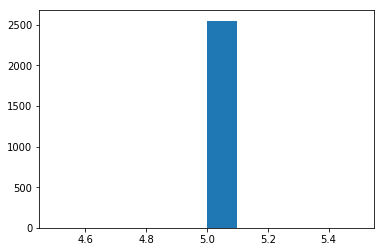

In [57]:
import matplotlib.pyplot as plt
plt.hist([len(R[image]) for image in R])
plt.show()

### Evaluation Module

In [22]:
import pickle
import numpy as np
from types import FunctionType


class EvalPerformance:
    def __init__(self, dict_correct: dict, dict_retrieved: dict) -> None:
        self.dict_correct = dict_correct # dict of correct retrievals for each query(= ground truth), {'1.jpg': 'correct_dup1.jpg'}
        self.dict_retrieved = dict_retrieved # dict of all retrievals for each query, {'1.jpg': 'retrieval_1.jpg'}

    @staticmethod
    def avg_prec(correct_duplicates: list, retrieved_duplicates: list) -> float:
        """Input: (list of correct duplicates (i.e., ground truth), list of retrieved duplicates) for one single query
        return: float representing average precision for one input query"""
        if not len(retrieved_duplicates):
            return 0.0
        count_real_correct = len(correct_duplicates)
        relevance = np.array([1 if i in correct_duplicates else 0 for i in retrieved_duplicates])
        relevance_cumsum = np.cumsum(relevance)
        prec_k = [relevance_cumsum[k] / (k + 1) for k in range(len(relevance))]
        prec_and_relevance = [relevance[k] * prec_k[k] for k in range(len(relevance))]
        avg_precision = np.sum(prec_and_relevance) / count_real_correct
        return avg_precision

    @staticmethod
    def ndcg(correct_duplicates: list, retrieved_duplicates: list) -> float:
        """Input: (list of correct duplicates (i.e., ground truth), list of retrieved duplicates) for one single query
                return: float representing Normalized discounted Cumulative Gain (NDCG) for one input query"""
        if not len(retrieved_duplicates):
            return 0.0
        relevance = np.array([1 if i in correct_duplicates else 0 for i in retrieved_duplicates])
        relevance_numerator = [2 ** (k) - 1 for k in relevance]
        relevance_denominator = [np.log2(k + 2) for k in
                                 range(len(relevance))]  # first value of denominator term should be 2

        dcg_terms = [relevance_numerator[k] / relevance_denominator[k] for k in range(len(relevance))]
        dcg_k = np.sum(dcg_terms)

        # get #retrievals
        # if #retrievals <= #ground truth retrievals, set score=1 for calculating idcg
        # else score=1 for first #ground truth retrievals entries, score=0 for remaining positions

        if len(dcg_terms) <= len(correct_duplicates):
            ideal_dcg = np.sum([1 / np.log2(k + 2) for k in range(len(dcg_terms))])
            ndcg = dcg_k / ideal_dcg
        else:
            ideal_dcg_terms = [1] * len(correct_duplicates) + [0] * (len(dcg_terms) - len(correct_duplicates))
            ideal_dcg_numerator = [(2 ** ideal_dcg_terms[k]) - 1 for k in range(len(ideal_dcg_terms))]
            ideal_dcg_denominator = [np.log2(k + 2) for k in range(len(ideal_dcg_terms))]
            ideal_dcg = np.sum([ideal_dcg_numerator[k] / ideal_dcg_denominator[k] for k in range(len(ideal_dcg_numerator))])
            ndcg = dcg_k / ideal_dcg
        return ndcg

    @staticmethod
    def jaccard_similarity(correct_duplicates: list, retrieved_duplicates: list) -> float:
        """Input: (list of correct duplicates (i.e., ground truth), list of retrieved duplicates) for one single query
                return: float representing jaccard similarity for one input query"""
        if not len(retrieved_duplicates):
            return 0.0
        set_correct_duplicates = set(correct_duplicates)
        set_retrieved_duplicates = set(retrieved_duplicates)

        intersection_dups = set_retrieved_duplicates.intersection(set_correct_duplicates)
        union_dups = set_retrieved_duplicates.union(set_correct_duplicates)

        jacc_sim = len(intersection_dups) / len(union_dups)
        return jacc_sim

    def mean_all_func(self, metric_func: FunctionType) -> float:
        """Input: metric function on which mean is to be calculated across all queries
                return: float representing mean of the metric across all queries"""
        all_metrics = []
        for k in self.dict_correct.keys():
            all_metrics.append(metric_func(self.dict_correct[k], self.dict_retrieved[k]))
        return np.mean(all_metrics)

    def get_all_metrics(self, save: bool=True) -> dict:
        """Input: Save flag indicating whether the dictionary below should be saved
        return: dictionary of all mean metrics"""
        dict_average_metrics = {
            'MAP': self.mean_all_func(self.avg_prec),
            'NDCG': self.mean_all_func(self.ndcg),
            'Jaccard': self.mean_all_func(self.jaccard_similarity)
        }

        if save:
            with open('all_average_metrics.pkl', 'wb') as f:
                pickle.dump(dict_average_metrics, f)
        return dict_average_metrics

In [23]:
import pickle
with open('/Users/zubin.john/forge/image-dedup/Transformed_dataset/ground_truth_transformed.pkl', 'rb') as rb:
    correct_dict = pickle.load(rb)

In [45]:
correct_dict

{'ukbench00002.jpg': ['ukbench00002_rotation.jpg',
  'ukbench00002_hflip.jpg',
  'ukbench00002_resize.jpg',
  'ukbench00002_cropped.jpg',
  'ukbench00002_vflip.jpg'],
 'ukbench00005.jpg': ['ukbench00005_rotation.jpg',
  'ukbench00005_hflip.jpg',
  'ukbench00005_resize.jpg',
  'ukbench00005_cropped.jpg',
  'ukbench00005_vflip.jpg'],
 'ukbench00009.jpg': ['ukbench00009_rotation.jpg',
  'ukbench00009_hflip.jpg',
  'ukbench00009_resize.jpg',
  'ukbench00009_cropped.jpg',
  'ukbench00009_vflip.jpg'],
 'ukbench00013.jpg': ['ukbench00013_rotation.jpg',
  'ukbench00013_hflip.jpg',
  'ukbench00013_resize.jpg',
  'ukbench00013_cropped.jpg',
  'ukbench00013_vflip.jpg'],
 'ukbench00017.jpg': ['ukbench00017_rotation.jpg',
  'ukbench00017_hflip.jpg',
  'ukbench00017_resize.jpg',
  'ukbench00017_cropped.jpg',
  'ukbench00017_vflip.jpg'],
 'ukbench00023.jpg': ['ukbench00023_rotation.jpg',
  'ukbench00023_hflip.jpg',
  'ukbench00023_resize.jpg',
  'ukbench00023_cropped.jpg',
  'ukbench00023_vflip.jpg']

In [47]:
e1 = EvalPerformance(correct_dict, R)
e1.get_all_metrics()

{'MAP': 1.0, 'NDCG': 1.0, 'Jaccard': 1.0}

## Appendix

In [28]:
## Unit test

from PIL import Image

x = np.array(Image.open('/Users/zubin.john/forge/image-dedup/Transformed_dataset/Retrieval/ukbench04754_vflip.jpg'))
y = Image.open('/Users/zubin.john/forge/image-dedup/Transformed_dataset/Retrieval/ukbench04754_vflip.jpg')           

assert dhash(Image.fromarray(x)) == dhash(y)